In [1]:
import numpy as np
from scipy.linalg import lapack, svd, qr, eig
import QRDM
import time
import QR
from auxil import *
import matplotlib.pyplot as plt

In [2]:
help(QRDM)

Help on module QRDM:

NAME
    QRDM - With this wrapper you can run the QRDM algorithm from Python.

FUNCTIONS
    DORMQR(...)
        LAPACK dormqr
    
    QP3(...)
        LAPACK QR with column pivoting (from lapacke)
    
    QRDM(...)
        Deviation Maximization QR
    
    init(...)
        initialize module

FILE
    /home/condivisione/Monica/dmrrqr/qrdm/QRDM.cpython-37m-x86_64-linux-gnu.so




In [3]:
matrix_layout = 102
m = 2**7
n = m
lda = m

In [4]:
#generate matrix with given sv distribution
M = max(m,n)
r = math.floor(min(m,n)*5/10)
# generate random matrix with
# condition number = O(gap)
U,X = qr(np.random.randn(M,M))
V,X = qr(np.random.randn(M,M)) 
gap = 1e-17
eigv = np.exp2(1- np.arange(1,M+1)) +gap 
eigv[:r] = eigv[:r] + 0.01*(r-np.arange(1,r+1));

X = U @ np.diag(eigv) @ V.T
print('n=', n)
#controllo il rango numerico
print("cond(X) = ", eigv[0]/eigv[-1], ", sigma_1 = ", eigv[0], "sigma_n = ", eigv[-1], "\n")


n= 128
cond(X) =  1.6299999999999997e+17 , sigma_1 =  1.63 sigma_n =  1e-17 



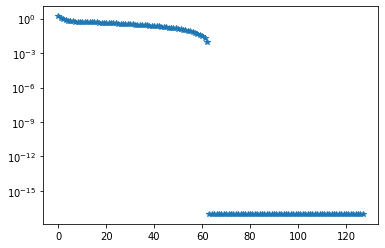

In [5]:
plt.semilogy(eigv, '*')

In [6]:
print('Numerical rank = ', r, np.amin(np.where(eigv<1e-13)[0])+1 )#np.argmin(eigv))

Numerical rank =  64 64


In [7]:
print('Chiamo QP3')
A = X.copy()
jpvt = np.ones((n,),dtype = np.int32)
tau = np.zeros((n,),dtype = np.float64)

tic = time.perf_counter()
#effettuo QR con pivoting
out = QRDM.QP3(matrix_layout, m,n,A,lda,jpvt,tau)
toc = time.perf_counter()
elQRP = toc-tic
print(f"Elapsed time QP3 {toc - tic:0.10f} seconds")
# controllo fattore Q
Q,R,err,errQ = checkQ(matrix_layout, m, n, A, X, tau, jpvt, verbose = True)

Chiamo QP3
Elapsed time QP3 0.0008928594 seconds
||Q.T*Q - I|| =  1.0829571410990832e-14
||A[:,p] - Q*R|| =  2.202779738070278e-15


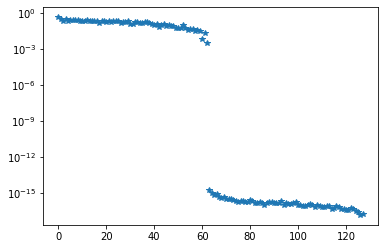

In [8]:
diagR = np.absolute(np.diag(R))
plt.semilogy(diagR, '*')

In [9]:
d = 0.9
t = 0.15
thres = np.array([d,1.0,t],dtype = np.float64) #1-0.3

In [10]:
print("\n***************************************\n")
print('QRDM, tau =',t,'delta =',d)
A = X.copy()
jpvt = np.zeros((n,),dtype = np.int32)
ncols = np.zeros((n+2,),dtype = np.int32) # cambiare zeros in ones o viceversa
tau = np.zeros((n,),dtype = np.float64)

tic = time.perf_counter()
#effettuo QR con pivoting
out = QRDM.QRDM(matrix_layout, m,n,A,lda,jpvt,tau, ncols,thres,0)
toc = time.perf_counter()
elDMQR = toc-tic
print(f"Elapsed time QRP {toc - tic:0.10f} seconds")
print('Numerical rank ', np.sum(ncols[:n]))
Q,R,err,errQ = checkQ(matrix_layout, m, n, A, X, tau, jpvt,  verbose = True)


***************************************

QRDM, tau = 0.15 delta = 0.9
Elapsed time QRP 0.0018925667 seconds
Numerical rank  128
||Q.T*Q - I|| =  1.1110787490429429e-14
||A[:,p] - Q*R|| =  2.374323047978664e-15


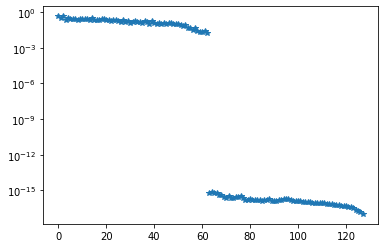

In [11]:
diagR = np.absolute(np.diag(R))
plt.semilogy(diagR, '*')

In [12]:
print("\n***************************************\n")
print('QRDM with stop, tau =',t,'delta =',d)
A = X.copy()
jpvt = np.zeros((n,),dtype = np.int32)
ncols = np.zeros((n+2,),dtype = np.int32) # cambiare zeros in ones o viceversa
ncols[0] = 1
tau = np.zeros((n,),dtype = np.float64)

tic = time.perf_counter()
#effettuo QR con pivoting
out = QRDM.QRDM(matrix_layout, m,n,A,lda,jpvt,tau, ncols,thres,0)
toc = time.perf_counter()
elDMQR = toc-tic
print(f"Elapsed time QRP {toc - tic:0.10f} seconds")
r_QRDM = np.sum(ncols[:n])
print('Numerical rank ', r_QRDM)
Q,R,err,errQ = checkQ(matrix_layout, m, n, A, X, tau, jpvt, k = r_QRDM, verbose = True)


***************************************

QRDM with stop, tau = 0.15 delta = 0.9
Elapsed time QRP 0.0050879200 seconds
Numerical rank  94
||Q.T*Q - I|| =  9.76286766079017e-15
||R_22||_2 =  7.941139236055216e-16
||A[:,p] - Q*R|| =  2.385738318378842e-15


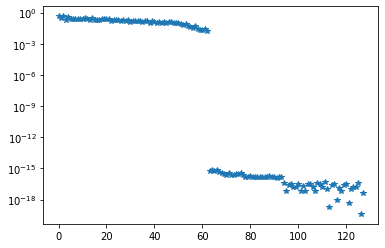

In [13]:
diagR = np.absolute(np.diag(R))
plt.semilogy(diagR, '*')